In [630]:
import sys
import os

import os
cwd = os.getcwd()
root_path = os.path.abspath('..')
sys.path.insert(0, root_path)


In [631]:
import re
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from utils.fs import RESULTS_RAW_DIR

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from utils.enums import Perspective

In [632]:
def get_latest_runs(n):
    def is_numeric(input):
        try:
            float(input)
            return True
        except ValueError:
            return False
        
    # Filter numeric folder names
    numeric_folders = [folder for folder in os.listdir(RESULTS_RAW_DIR) if is_numeric(folder) and os.path.isdir(os.path.join(RESULTS_RAW_DIR, folder))]

    if numeric_folders:
        # Sort folders by their numeric value, in descending order
        sorted_folders = sorted(numeric_folders, key=lambda x: float(x), reverse=True)
        
        # Get the latest n runs
        latest_n_runs = sorted_folders[:n]
        
        print(f"The latest {n} runs are: {latest_n_runs}")
        return latest_n_runs
    else:
        print("No runs found.")
        return None

In [633]:
def load_results(run_name, verbose=False):
    run_path = os.path.join(RESULTS_RAW_DIR, run_name)
    npy_files = [file for file in os.listdir(run_path) if file.endswith('.npy')]

    loaded_data = {}

    # Load each .npy file and use the file name (without extension) as the key
    for npy_file in npy_files:
        file_path = os.path.join(run_path, npy_file)
        key = os.path.splitext(npy_file)[0]  # Get the file name without .npy extension
        loaded_data[key] = np.load(file_path)

        if verbose: print(f"{loaded_data[key].shape} \t {key}")

    return loaded_data

In [634]:
def get_buckets(keys):
    buckets = set()
    for key in keys:
        numbers = re.findall(r'\d+', key)
        buckets.update(map(int, numbers))
    if len(buckets) > 0:
        return sorted(buckets)
    else:
        return None

In [635]:
from sklearn.metrics import precision_recall_curve

def filter(list, string):
    return [item for item in list if string in item]

def calculate_f1(precision, recall):
    # Check if both precision and recall are zero to avoid division by zero
    precision[precision == 0] = 1e-6
    recall[recall == 0] = 1e-6

    if np.any(precision != 0) and np.any(recall != 0):
        return (2 * precision * recall) / (precision + recall)
    else:
        return 0
    
def _calculate_results(perspective_index, perspective, bucket, level, level_label_keys, level_result_keys, results, verbose):
    if verbose: print(perspective_index, perspective)

    # Get the key names
    if bucket is not None:
        true_key = filter(level_label_keys, f'_{bucket}')
        pred_prob_key = filter(level_result_keys, f'{perspective}_{bucket}')
    else:
        true_key = level_label_keys
        pred_prob_key = filter(level_result_keys, f'{perspective}')
    if verbose: print(true_key, pred_prob_key)

    # Check if the files exist by checking the length
    if len(true_key) != 1 or len(pred_prob_key) != 1:
        if verbose: print(f'Skipping as {perspective} has not been found.')
        return None
    else:
        true_key = true_key[0]
        pred_prob_key = pred_prob_key[0]
        if verbose: print(true_key, pred_prob_key)

    # Get the values by key
    pred_prob = np.array(results[pred_prob_key],dtype=np.float32)
    if level == 'trace':
        y_true = np.array(results[true_key][:,perspective_index],dtype=np.float32)
    elif level == 'event':
        # Also need to take the bucket_size into account
        if bucket is None:
            y_true = np.array(results[true_key][:,:,perspective_index],dtype=np.float32)
        else:
            y_true = np.array(results[true_key][:,:bucket,perspective_index],dtype=np.float32)
    else: #attribute
        if bucket is None:
            y_true = np.array(results[true_key][:,:,:,perspective_index],dtype=np.float32)
        else:
            y_true = np.array(results[true_key][:,:bucket,:,perspective_index],dtype=np.float32)

    if verbose: print(y_true.shape, pred_prob.shape)

    y_true = y_true.flatten()
    pred_prob = pred_prob.flatten()

    # Check if all y_true values are 0 (most likely indicates a problem with an earlier step)
    if np.all(y_true == 0):
        if verbose: print(f'No positive class found for {true_key},{pred_prob_key}')
        return None

    # print(true, len(true))
    # print(pred_prob, len(pred_prob))
    if verbose: print(y_true.shape, pred_prob.shape)

    precision, recall, thresholds = precision_recall_curve(y_true=y_true, probas_pred=pred_prob)
    # print(precision.shape)
    # print(recall.shape)
    f1s=calculate_f1(precision,recall)
    f1s[np.isnan(f1s)] = 0
    # print(f1s)
    best_index=np.argmax(f1s)
    # if True: print(best_index, len(f1s), f1s[best_index])
    return (pred_prob_key,f1s[best_index],thresholds[best_index])

def calculate_results(results, level, verbose=False):
    level_file_keys = filter(results.keys(), level)
    level_label_keys = filter(level_file_keys, 'label')
    level_result_keys = filter(level_file_keys, 'result')
    bucket_lengths = get_buckets(level_file_keys)

    if verbose: print(results.keys())

    f1_scores = []
    for perspective_index, perspective in enumerate(Perspective.values()):
        if bucket_lengths is None:
            f1_score = _calculate_results(perspective_index, perspective, None, level, level_label_keys, level_result_keys, results, verbose)
            if f1_score is not None:
                f1_scores.append(f1_score)
        else:
            for bucket in bucket_lengths:
                f1_score = _calculate_results(perspective_index, perspective, bucket, level, level_label_keys, level_result_keys, results, verbose)
                if f1_score is not None:
                    f1_scores.append(f1_score)
    return f1_scores

In [636]:
def plot_f1_scores(title, label_list, results_lists):
    # Prepare the data for multiple lists
    all_names = set()
    for trace_results in results_lists:
        all_names.update([item[0] for item in trace_results])
    
    all_names = sorted(all_names)  # Sort names to maintain consistency in bar positions
    name_indices = np.arange(len(all_names))  # Create an index for each name
    
    # Initialize plot
    plt.figure(figsize=(12, 6))
    # bar_width = 0.2  # Set the width of each bar
    offset = 0  # To shift bars for different lists
    num_lists = len(results_lists)
    bar_width = 0.9 / num_lists  # Reduce bar width based on the number of lists
    # offset = -(bar_width * num_lists) / 2  # Start offset for centering the bars
    
    # Plot bars for each result list
    for i, (label, trace_results) in enumerate(zip(label_list, results_lists)):
        names = [item[0] for item in trace_results]
        values = [item[1] for item in trace_results]
        
        # Align the values with all possible names, filling in 0 for missing values
        aligned_values = [values[names.index(name)] if name in names else 0 for name in all_names]
        
        # Create the bar chart with offset
        plt.barh(name_indices + offset, aligned_values, bar_width, label=label)
        offset += bar_width  # Update the offset for the next set of bars
    
    # Set labels, ticks, and title
    plt.xlabel('F1 Score')
    plt.ylabel('Trace Results')
    plt.yticks(name_indices + bar_width / 2, all_names)  # Center ticks between bars
    plt.title(f'Bar Chart of {title}')
    plt.legend()
    
    # Show plot
    plt.tight_layout()
    plt.show()

In [637]:
def analyze_run(run_list,name_list,title,verbose=False):
    results_traces = []
    results_events = []
    results_attributes = []
    for run in run_list:
        results = load_results(run_name=run, verbose=verbose)

        results_traces.append(calculate_results(results, 'trace', verbose=verbose))
        results_events.append(calculate_results(results, 'event', verbose=verbose))
        #results_traces.append(f1_scores_attributes = calculate_results(results, 'attribute', verbose=True))

    plot_f1_scores(title=f'Trace Level - {title}', label_list=name_list, results_lists=results_traces)
    plot_f1_scores(title=f'Event Level - {title}', label_list=name_list, results_lists=results_events)
    # plot_f1_scores(title=f'Attribute Level -  {title}', name_list=name_list, results_lists=results_attributes)

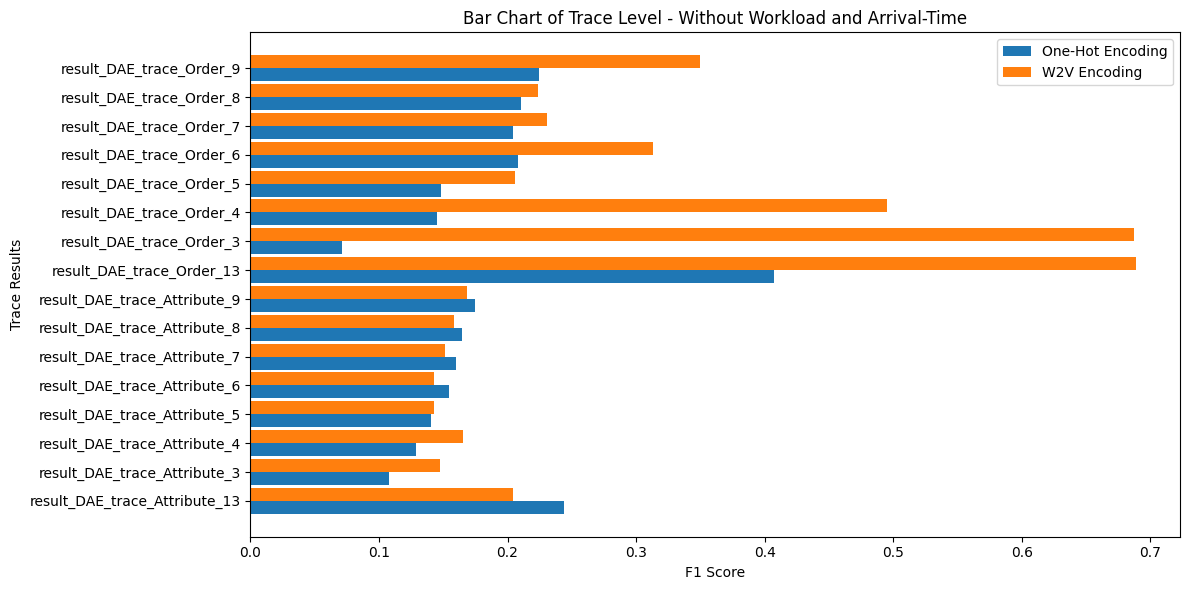

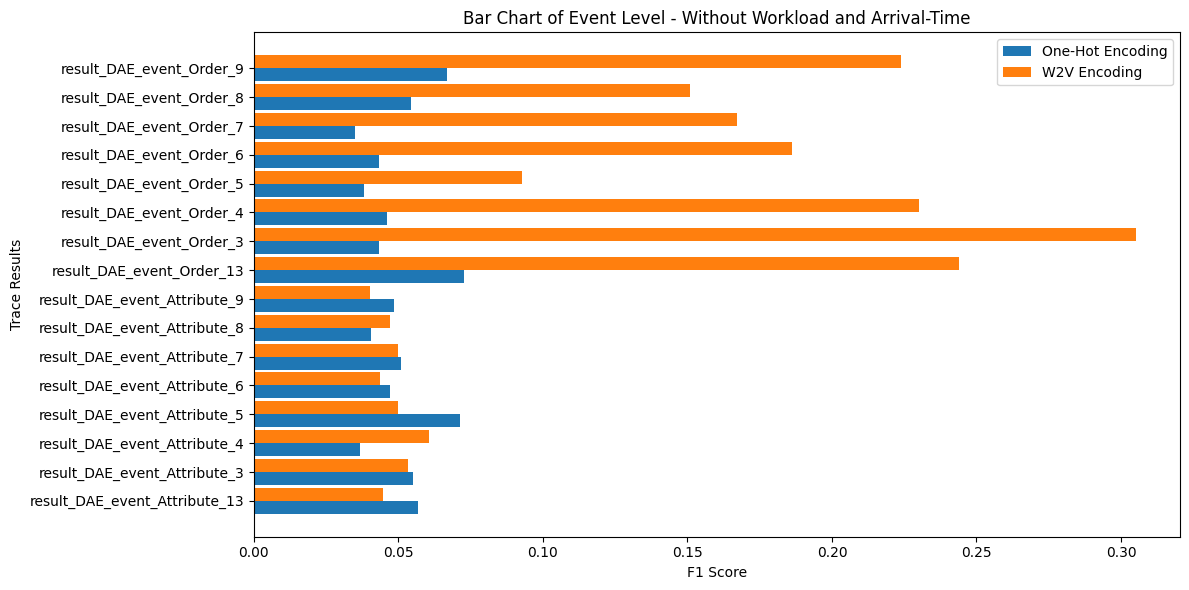

In [638]:
# Batch size 1 no workload and arrival-time
analyze_run(run_list=['1728578777.6577284','1728588822.2824156'],name_list=['One-Hot Encoding','W2V Encoding'],title='Without Workload and Arrival-Time')

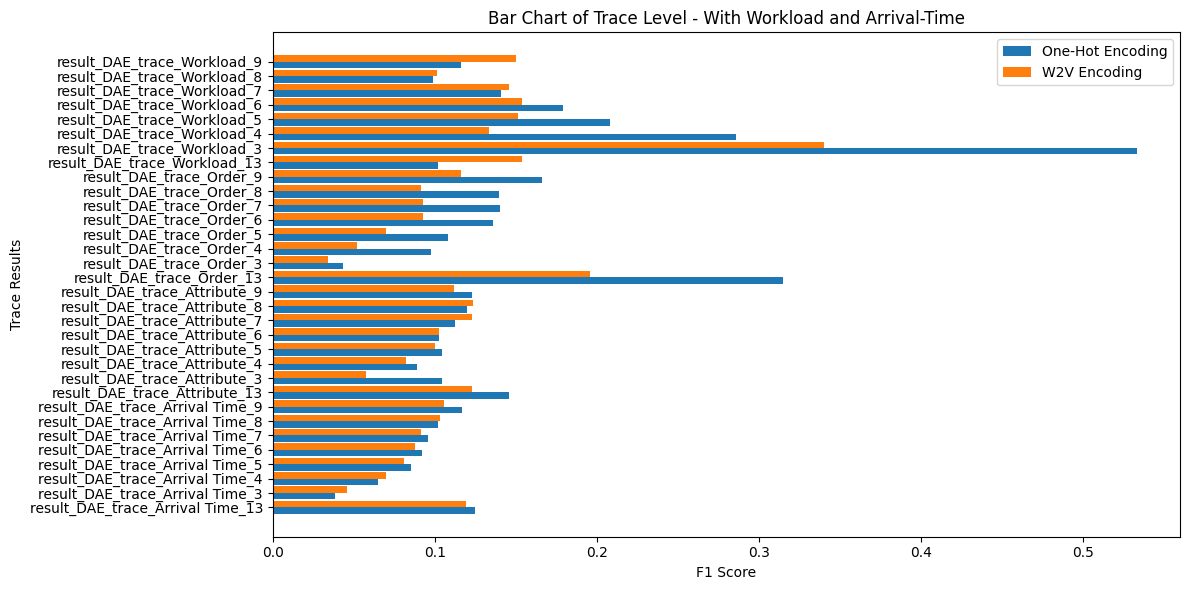

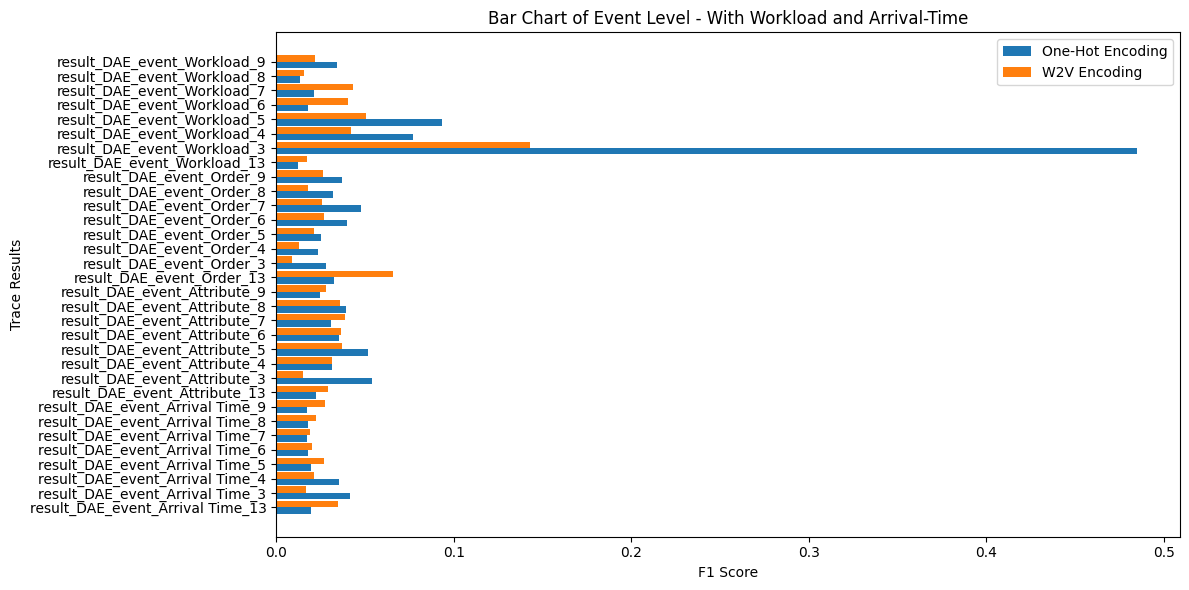

In [639]:
analyze_run(run_list=['1728590665.0445852','1728591204.6252553'],name_list=['One-Hot Encoding','W2V Encoding'],title='With Workload and Arrival-Time')

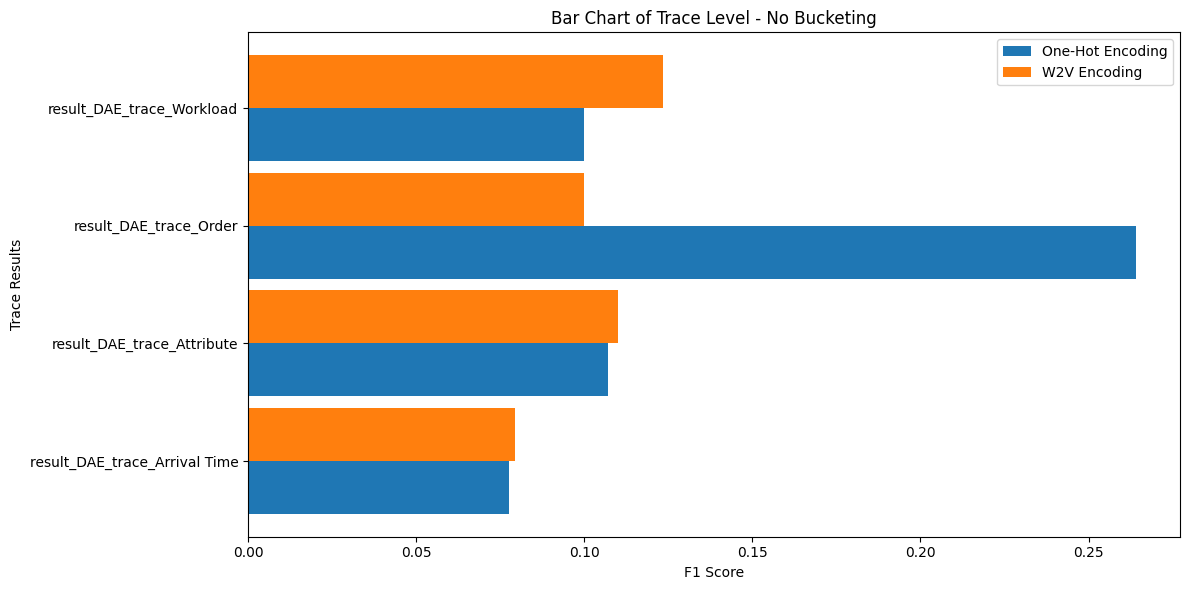

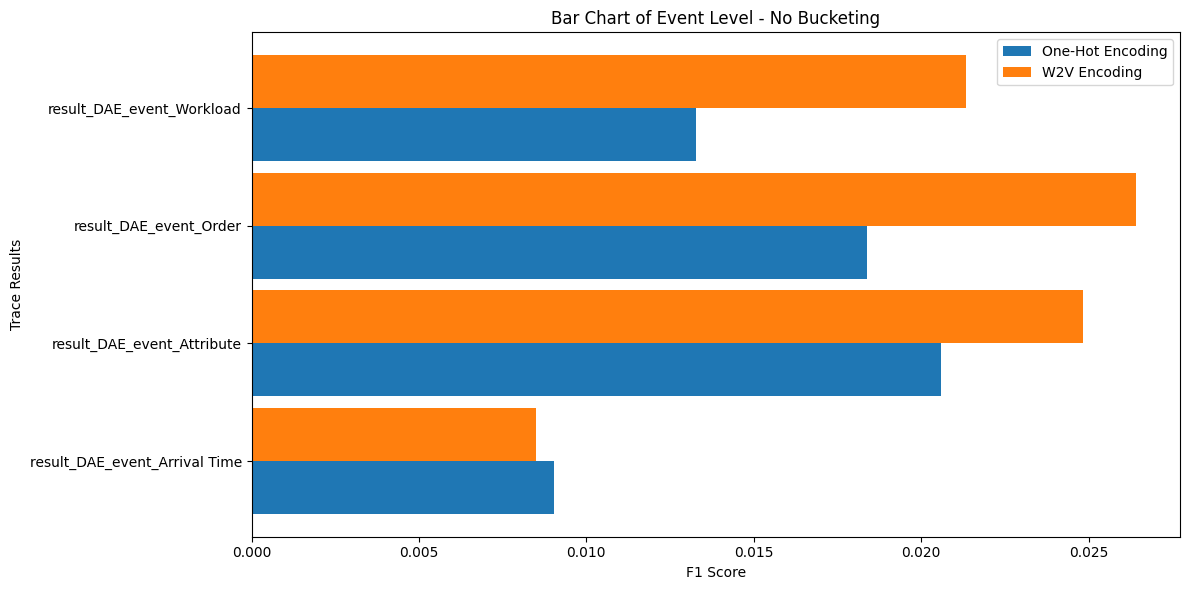

In [643]:
# '1728593508.1388857' {'batch_size': 1, 'prefix': True, 'bucket_boundaries': None, 'categorical_encoding': <EncodingCategorical.ONE_HOT: 'One Hot'>, 'numerical_encoding': <EncodingNumerical.MIN_MAX_SCALING: 'Min Max Scaling'>, 'w2v_vector_size': 100, 'w2v_window_size': 10}
# '1728593013.9510126' {'batch_size': 1, 'prefix': True, 'bucket_boundaries': None, 'categorical_encoding': <EncodingCategorical.WORD_2_VEC: 'Word2Vec'>, 'numerical_encoding': <EncodingNumerical.MIN_MAX_SCALING: 'Min Max Scaling'>, 'w2v_vector_size': 100, 'w2v_window_size': 10}

analyze_run(run_list=['1728593508.1388857','1728593013.9510126'],name_list=['One-Hot Encoding','W2V Encoding'],title='No Bucketing',verbose=False)

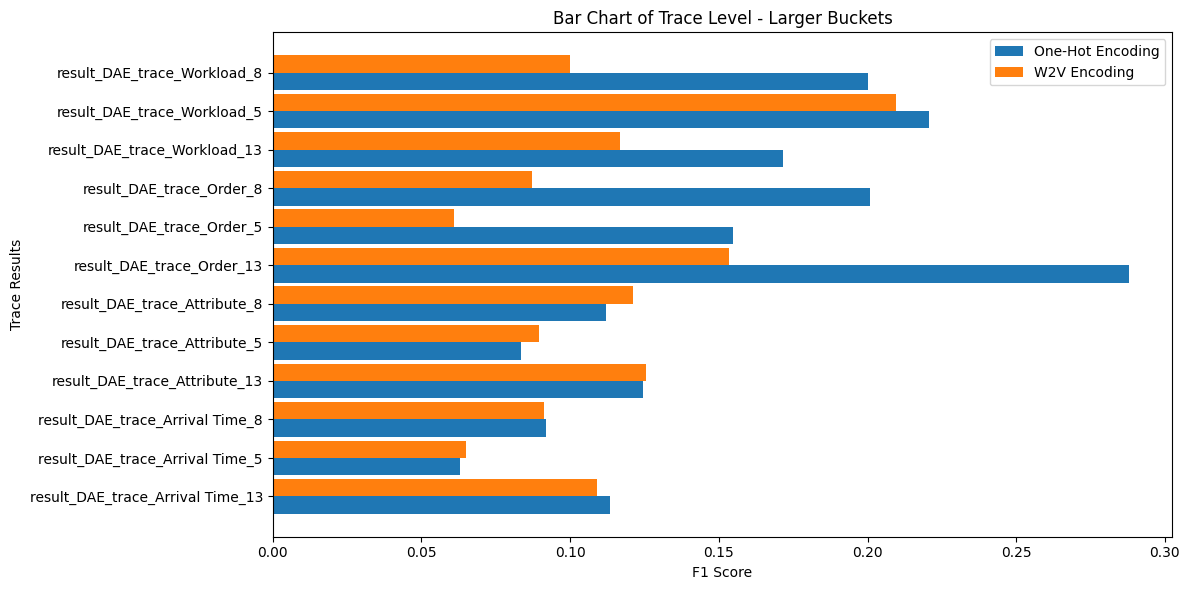

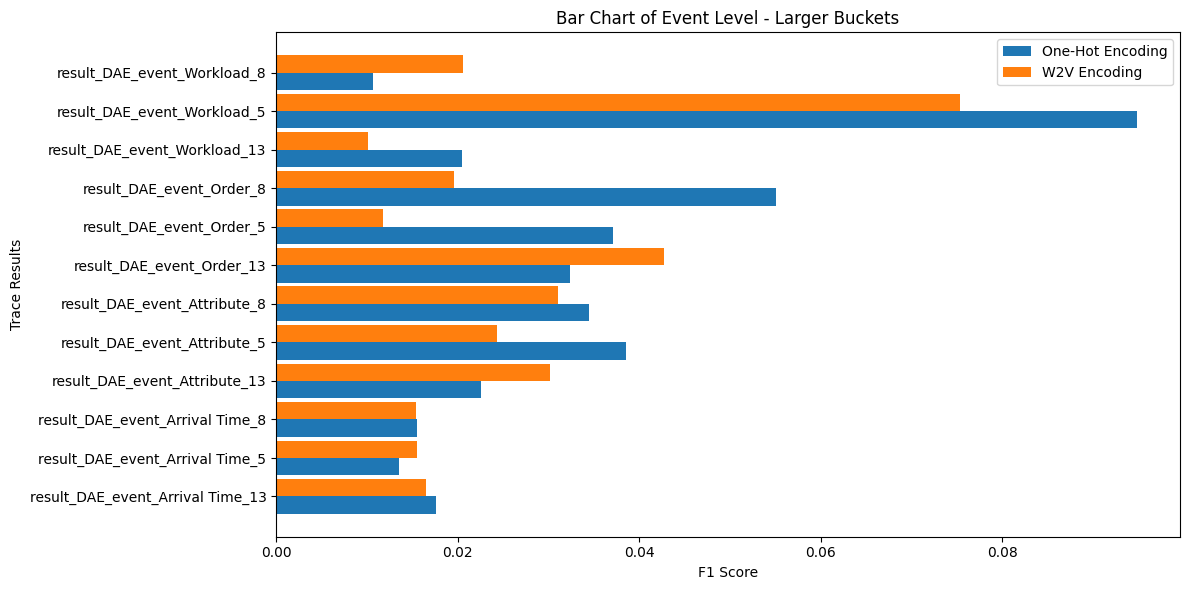

In [644]:
#'1728594646.464157' {'batch_size': 1, 'prefix': True, 'bucket_boundaries': [5, 8], 'categorical_encoding': <EncodingCategorical.ONE_HOT: 'One Hot'>, 'numerical_encoding': <EncodingNumerical.MIN_MAX_SCALING: 'Min Max Scaling'>, 'w2v_vector_size': 100, 'w2v_window_size': 10} None
#'1728594178.9124053' {'batch_size': 1, 'prefix': True, 'bucket_boundaries': [5, 8], 'categorical_encoding': <EncodingCategorical.WORD_2_VEC: 'Word2Vec'>, 'numerical_encoding': <EncodingNumerical.MIN_MAX_SCALING: 'Min Max Scaling'>, 'w2v_vector_size': 100, 'w2v_window_size': 10} None

analyze_run(run_list=['1728594646.464157','1728594178.9124053'],name_list=['One-Hot Encoding','W2V Encoding'],title='Larger Buckets')

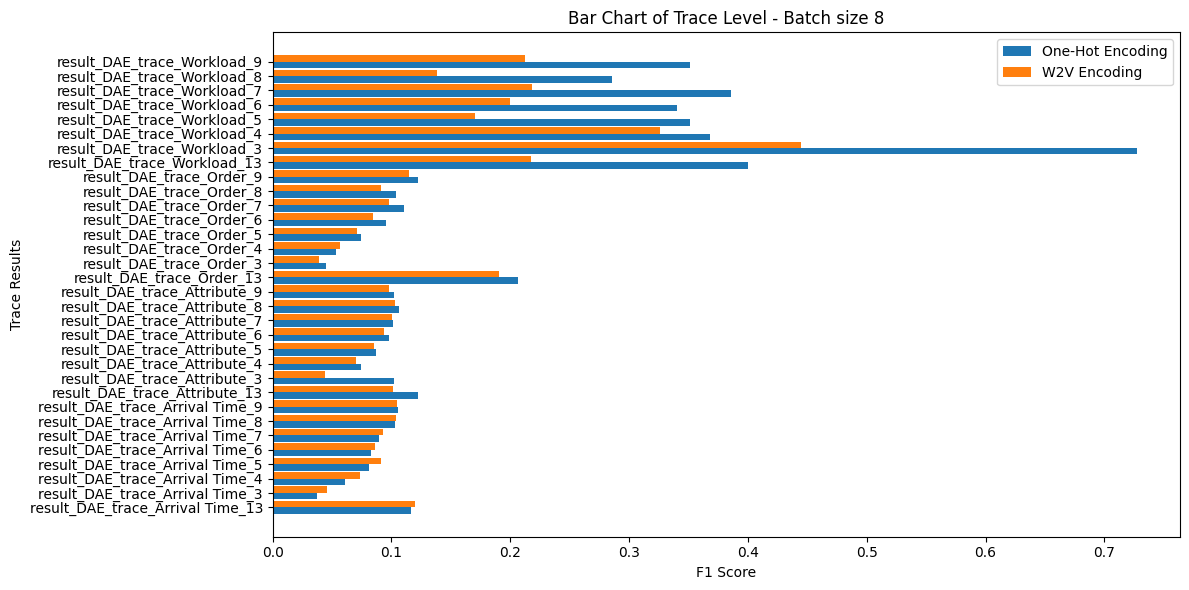

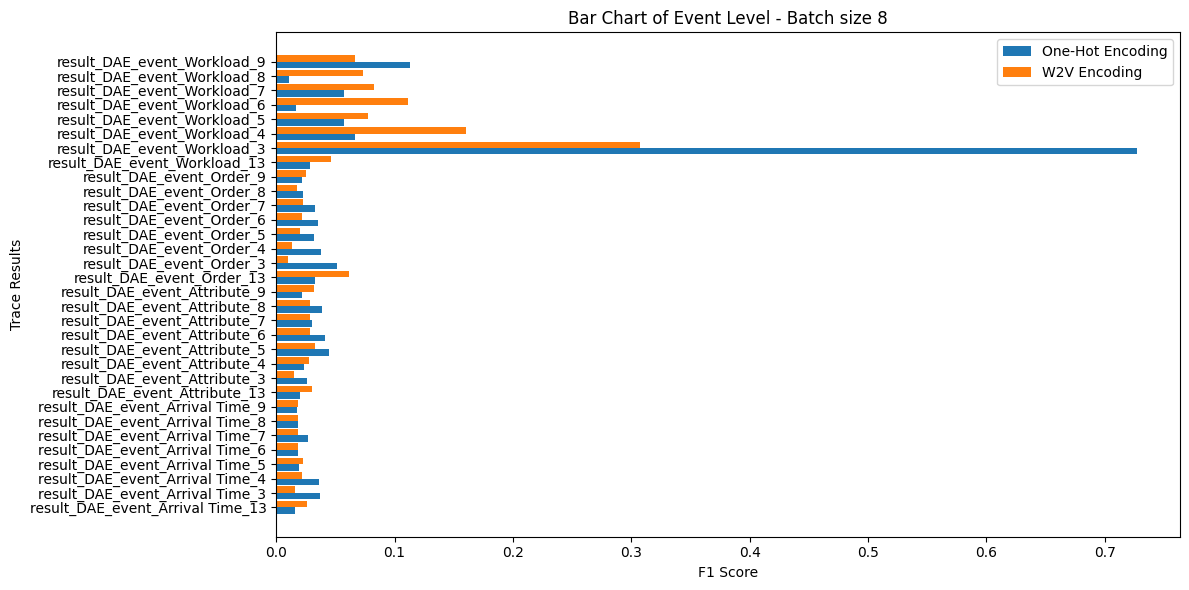

In [645]:
#'1728595155.5979335' {'batch_size': 8, 'prefix': True, 'bucket_boundaries': [3, 4, 5, 6, 7, 8, 9], 'categorical_encoding': <EncodingCategorical.WORD_2_VEC: 'Word2Vec'>, 'numerical_encoding': <EncodingNumerical.MIN_MAX_SCALING: 'Min Max Scaling'>, 'w2v_vector_size': 100, 'w2v_window_size': 10} None
#'1728595236.788436' {'batch_size': 8, 'prefix': True, 'bucket_boundaries': [3, 4, 5, 6, 7, 8, 9], 'categorical_encoding': <EncodingCategorical.ONE_HOT: 'One Hot'>, 'numerical_encoding': <EncodingNumerical.MIN_MAX_SCALING: 'Min Max Scaling'>, 'w2v_vector_size': 100, 'w2v_window_size': 10} None 

analyze_run(run_list=['1728595236.788436','1728595155.5979335'],name_list=['One-Hot Encoding','W2V Encoding'],title='Batch size 8')